In [1]:
import proplot as plot
import numpy as np
import yaml
import glob
import copy
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "WARNING"))

In [3]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect
from pizza_cutter_sims.stars import mask_and_interp_stars

with open(glob.glob("ref_config.yaml")[0]) as fp:
    base_cfg = yaml.safe_load(fp.read())
    
base_cfg["se"]["n_images"] = 2
base_cfg["pizza_cutter"]["single_epoch_config"]["spline_interp_flags"] = [7]

In [7]:
import tqdm

rng = np.random.RandomState(seed=10)
seeds = rng.randint(low=1, high=2**29, size=5)

all_msk_keys = ["bad_columns", "cosmic_rays", "streaks", "star"]
results = {}
for msk_key in tqdm.tqdm(["star"]):
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    star_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])
    mdet_rng = np.random.RandomState(seed=seeds[3])

    cfg = copy.deepcopy(base_cfg)
    for key in all_msk_keys:
        if key != "star":
            cfg["msk"][key] = False
    for key in all_msk_keys:
        if key == "star":
            continue
        cfg["msk"][key] = True
        if key == msk_key:
            break
    
    if msk_key == "star":
        cfg["star"]["dens_factor"] = 10
    else:
        cfg["star"]["dens_factor"] = 0

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        star_rng=star_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        star_config=cfg["star"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            img=data["img"],
            wgt=data["wgt"],
            msk=data["msk"],
            bkg=data["bkg"],
            info=data["info"],
            n_extra_noise_images=0,
        )
        
    mask_and_interp_stars(cdata=cdata, stars=data["stars"], rng=star_rng)
    
    results[msk_key] = cdata

100%|██████████| 1/1 [00:23<00:00, 23.54s/it]


In [ ]:
vmin = np.inf
vmax = -np.inf

for i, key in enumerate(all_msk_keys):
    img = results[key]["image"]
    wgt = results[key]["weight"]
    ormask = results[key]["ormask"]
    vv = np.arcsinh(img*np.sqrt(wgt))
    vmin = min(np.min(vv), vmin)
    vmax = max(np.max(vv), vmax)

fig, axs = plot.subplots(nrows=2, ncols=4, share=3)
for i, key in enumerate(all_msk_keys):
    img = results[key]["image"]
    wgt = results[key]["weight"]
    ormask = results[key]["ormask"]
    ax = axs[0, i]
    ax.imshow(np.arcsinh(img*np.sqrt(wgt)), cmap="rocket", vmin=vmin, vmax=vmax)
    ax.grid(False)
    ax.format(xtickloc='neither', ytickloc='neither')
    
    ax = axs[1, i]
    ax.imshow(ormask.astype(bool), cmap="gray_r", vmin=0, vmax=1)    
    ax.grid(False)
    ax.format(xtickloc='neither', ytickloc='neither')
    
fig.savefig("msk.png")

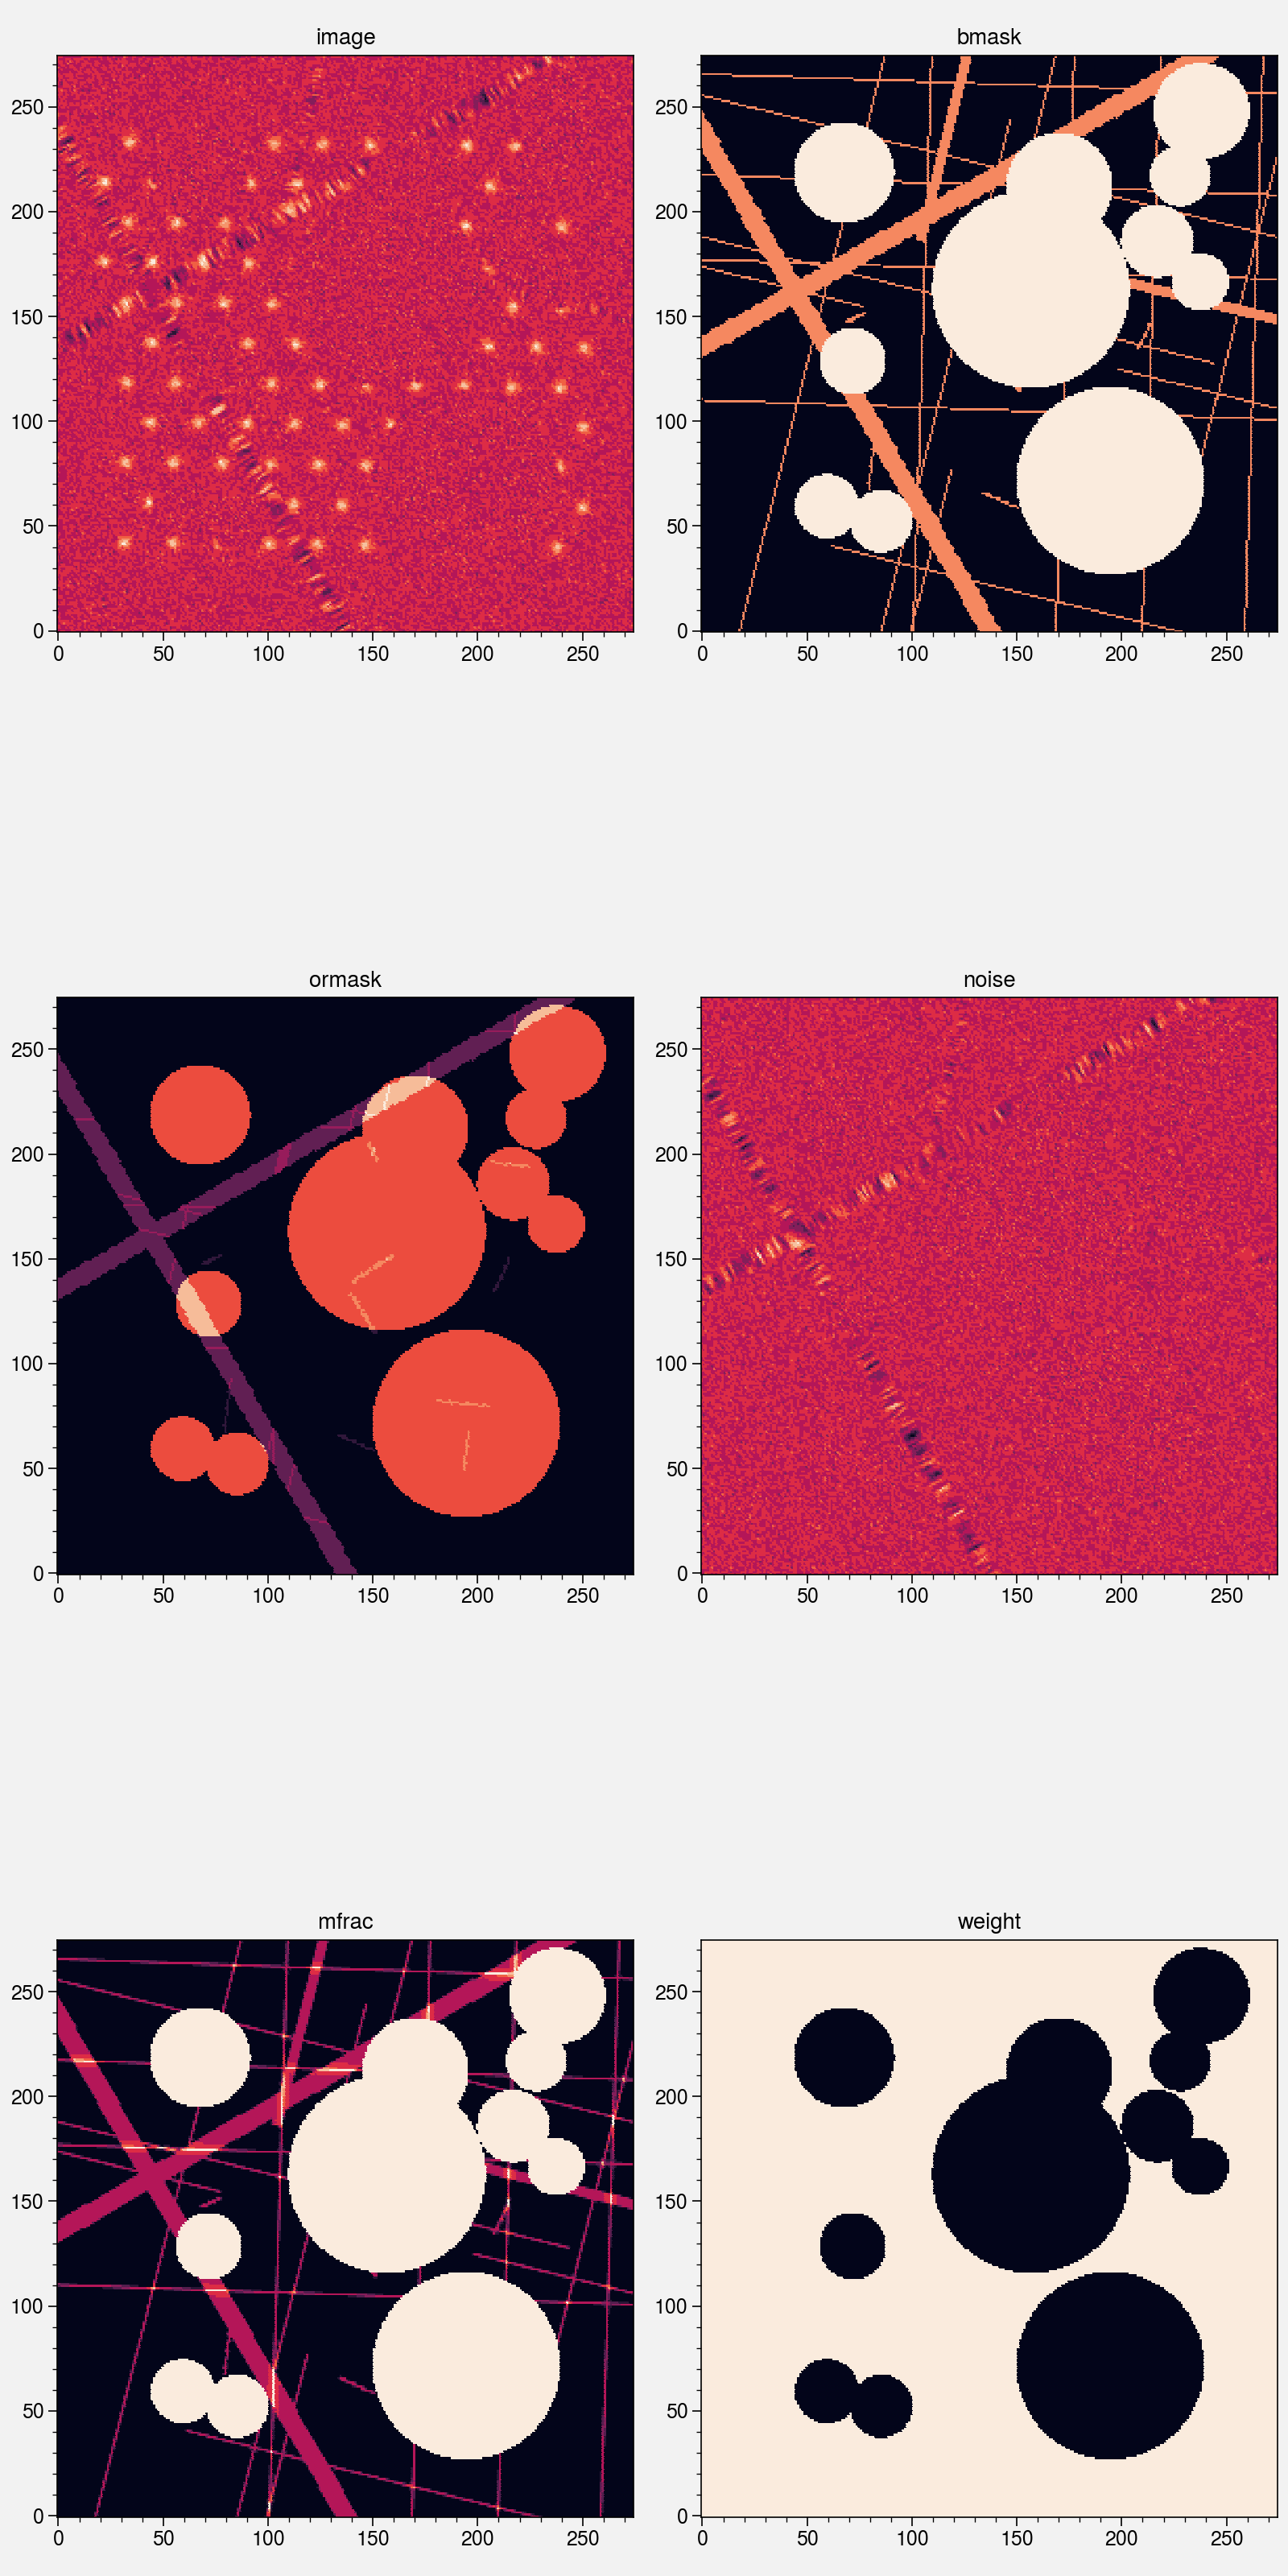

In [8]:
fig, axs = plot.subplots(nrows=3, ncols=2, figsize=(8, 16), share=0)
cdata = results["star"]

for i, key in enumerate(["image", "bmask", "ormask", "noise", "mfrac", "weight"]):
    axs[i].pcolormesh(cdata[key], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)

Text(0.5, 1.0, 'image')

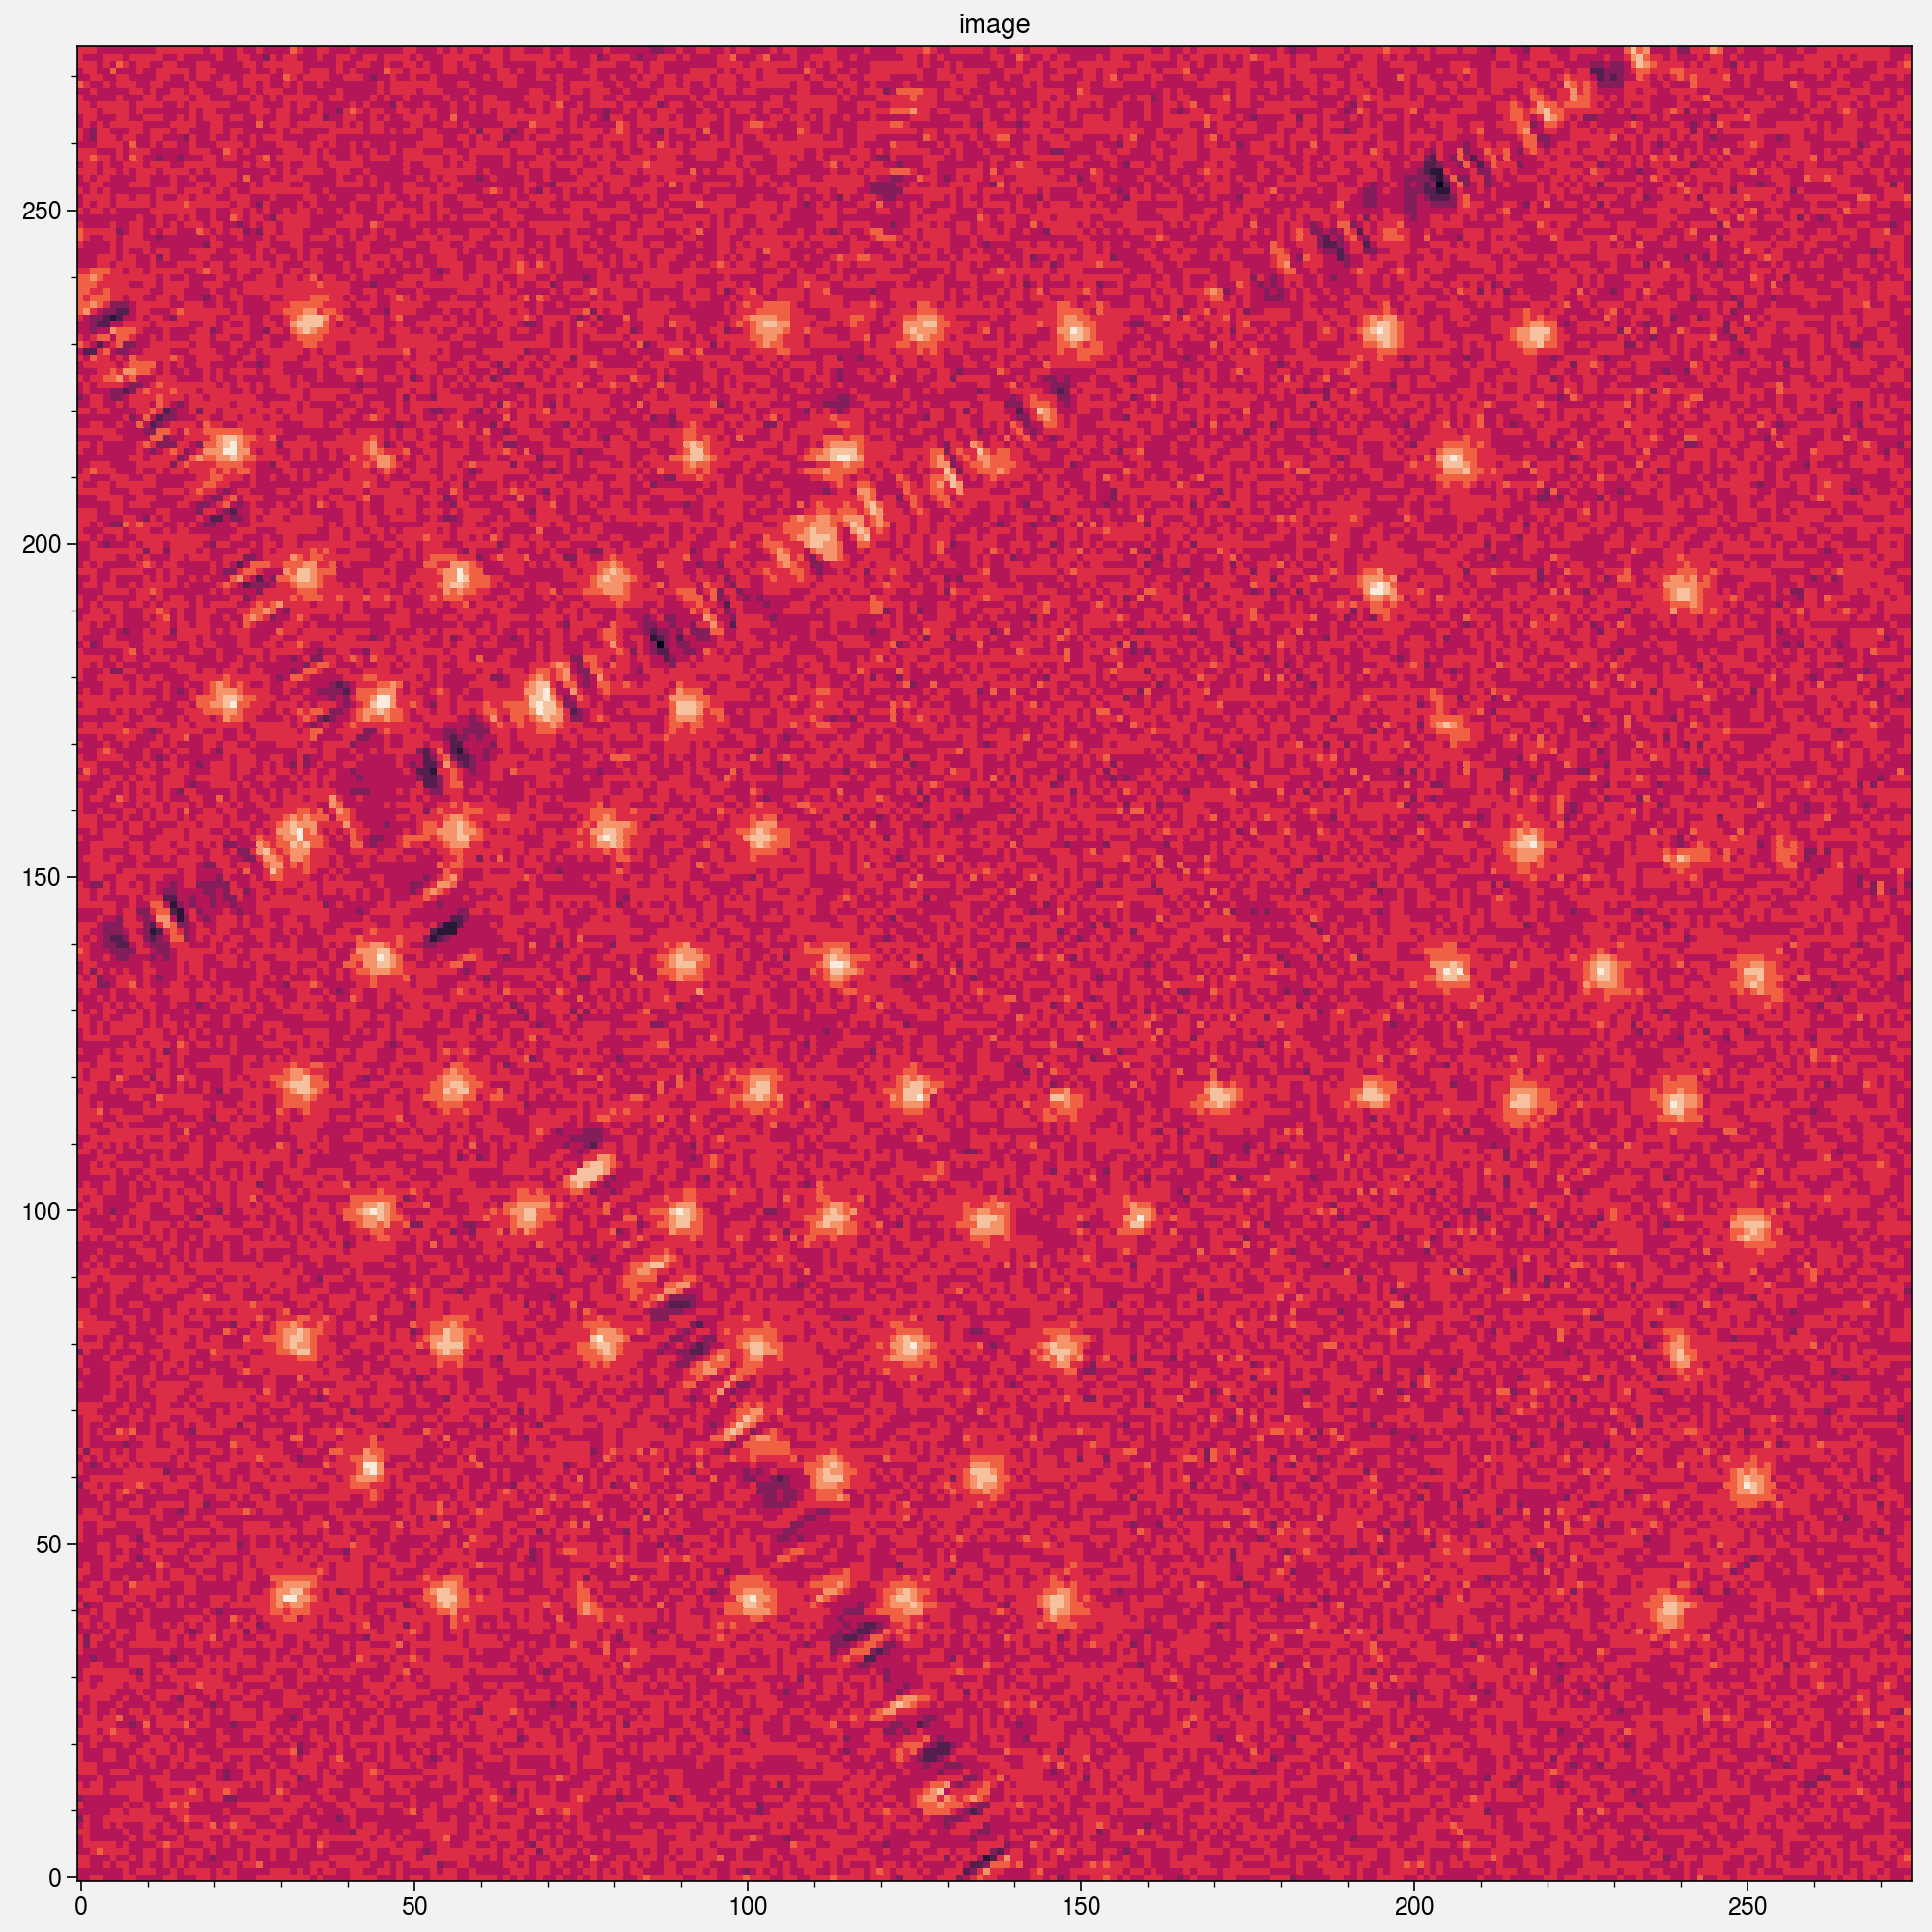

In [9]:
fig, axs = plot.subplots(figsize=(10, 10))
cdata = results["star"]

key = "image"
axs.pcolormesh(cdata[key], cmap="rocket")
axs.set_aspect(1)
axs.set_title(key)